# Logistic Regression + TF-IDF (Baseline)

In [1]:
# Baseline ABSA with Logistic Regression + TF-IDF (weak supervision)
import os, re, json, math, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_colwidth", 200)
SEED = 42
random.seed(SEED); np.random.seed(SEED)


In [2]:
DATA_DIR = "/Users/rachelyu/Desktop/Yelp JSON/yelp_dataset"

BUSINESS_FP = os.path.join(DATA_DIR, "yelp_academic_dataset_business.json")
REVIEW_FP   = os.path.join(DATA_DIR, "yelp_academic_dataset_review.json")

# Performance/speed knobs for quick iteration
MAX_RESTAURANTS = 300_000   # upper bound; keep large, we'll filter anyway
MAX_REVIEWS     = 120_000   # process at most this many restaurant reviews
SAMPLE_REVIEWS  = 80_000    # optional downsample after filtering
MIN_SENT_LEN    = 15        # ignore super short sentences
MAX_SENT_PER_REVIEW = 8     # cap sentences per review to limit explosion

# Weak supervision thresholds (review-level → sentence label)
POS_THRESH = 4              # stars >= 4 → positive
NEG_THRESH = 2              # stars <= 2 → negative

# Class balancing
MAX_PER_ASPECT_PER_CLASS = 30_000  # to avoid massive imbalance

In [ ]:
# Aspect keywords (simple, transparent baseline)
ASPECT_KEYWORDS = {
    "service": [
        "service","waiter","waitress","server","staff","rude","slow","friendly","attentive",
        "host","hostess","manager","line","queue","checkout","barista"
    ],
    "food": [
        "food","dish","meal","portion","taste","tasty","delicious","bland","overcooked",
        "undercooked","menu","entree","appetizer","dessert","coffee","latte","espresso",
        "tea","pastry","bread","burger","noodle","soup","sushi","pizza"
    ],
    "ambience": [
        "ambience","ambiance","atmosphere","music","noise","noisy","loud","quiet",
        "decor","lighting","seat","seating","table","clean","dirty","vibe","cozy","crowded"
    ],
    "pricing": [
        "price","prices","pricey","expensive","cheap","affordable","value","cost","worth",
        "tip","tipping","surcharge","fee","fees","overpriced","underpriced","deal"
    ],
}

# Precompile aspect regexes
ASPECT_PATTERNS = {
    a: re.compile(r"\b(" + "|".join(map(re.escape, kws)) + r")\b", flags=re.IGNORECASE)
    for a, kws in ASPECT_KEYWORDS.items()
}

def detect_aspects(sentence: str):
    """Return list of aspects mentioned in a sentence based on simple keyword hits."""
    hits = []
    for a, pat in ASPECT_PATTERNS.items():
        if pat.search(sentence):
            hits.append(a)
    return hits


In [4]:
SENT_SPLIT_RE = re.compile(r"(?<=[\.\!\?])\s+")

def split_into_sentences(text: str):
    # Simple regex-based splitter (no external downloads)
    sents = [s.strip() for s in SENT_SPLIT_RE.split(text) if s.strip()]
    return sents

def clean_text(s: str):
    # Minimal cleaning; keep case for TF-IDF (vectorizer will lowercase)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [5]:
def is_restaurant_category(cats: str) -> bool:
    if not isinstance(cats, str):
        return False
    cats_l = cats.lower()
    return any(kw in cats_l for kw in ["restaurant", "food", "cafe", "coffee", "tea shop", "tea room", "diner", "bistro"])

restaurant_biz_ids = set()
categories_map = {}

# Read business json (line-delimited)
with pd.read_json(BUSINESS_FP, lines=True, chunksize=50_000) as reader:
    for chunk in reader:
        chunk = chunk[["business_id","categories"]]
        chunk["is_restaurant"] = chunk["categories"].apply(is_restaurant_category)
        filt = chunk[chunk["is_restaurant"]].head(MAX_RESTAURANTS)
        restaurant_biz_ids.update(filt["business_id"].tolist())
        categories_map.update(dict(zip(filt["business_id"], filt["categories"].fillna("").astype(str))))

len(restaurant_biz_ids)


64629

In [6]:
kept_reviews = []

with pd.read_json(REVIEW_FP, lines=True, chunksize=100_000) as reader:
    for chunk in reader:
        chunk = chunk[["review_id","business_id","stars","text"]]
        chunk = chunk[chunk["business_id"].isin(restaurant_biz_ids)]
        if not chunk.empty:
            kept_reviews.append(chunk)
        # Stop if we've hit MAX_REVIEWS (approx)
        total = sum(len(df) for df in kept_reviews)
        if total >= MAX_REVIEWS:
            break

reviews_df = pd.concat(kept_reviews, ignore_index=True) if kept_reviews else pd.DataFrame(columns=["review_id","business_id","stars","text"])

# Optional downsample for speed
if SAMPLE_REVIEWS and len(reviews_df) > SAMPLE_REVIEWS:
    reviews_df = reviews_df.sample(SAMPLE_REVIEWS, random_state=SEED).reset_index(drop=True)

reviews_df.shape, reviews_df.head(3)


((80000, 4),
                 review_id             business_id  stars  \
 0  sWlmhJ2xzT13tYPqKD08Og  jQBPO3rYkNwIaOdQS5ktgQ      4   
 1  ArAaYmzvbTb-7SeH0Shncg  _GwN0kWZOs3DFpNDZIblRw      3   
 2  gkiz5ypTstmrlrt2k6VE3Q  C1D2o1VV2TDjpkG3BsdseA      4   
 
                                                                                                                                                                                                       text  
 0  Some of the best ice-cream I've eaten in St Louis. They have a sign explaining why their ice-cream is so good. Go for the ice-cream you will not be disappointed. This business is in a fun part of ...  
 1  I had the four cheese ravioli  and enjoyed myself.  I wish the portion was larger.  Otherwise, I was satisfied.  I also sampled the BBQ pork sandwich.  I found that to be delicious.  The price is ...  
 2  Nowhere else in Nashville is something magical so closely tied to something miserable.\n\nThe magical: a SATCO fajita. 

In [7]:
rows = []
pos_ct = neg_ct = 0

for i, row in reviews_df.iterrows():
    stars = row["stars"]
    if pd.isna(stars):
        continue

    # Weak label from stars
    if stars >= POS_THRESH:
        label = "pos"
    elif stars <= NEG_THRESH:
        label = "neg"
    else:
        # drop neutral (3-star) for cleaner baseline signal
        continue

    text = clean_text(str(row["text"]))
    sents = split_into_sentences(text)[:MAX_SENT_PER_REVIEW]

    for s in sents:
        if len(s) < MIN_SENT_LEN:
            continue
        aspects = detect_aspects(s)
        if not aspects:
            continue
        for a in aspects:
            rows.append({
                "text": s,
                "aspect": a,
                "label": label,
                "stars": stars,
                "business_id": row["business_id"],
            })

df_sent = pd.DataFrame(rows)
df_sent.shape, df_sent.head(5)


((174110, 5),
                                                                                                                                                       text  \
 0                                                                                                                The pain, however, is far worth the gain.   
 1                                                                                                                         Great place for a cup of coffee.   
 2  I have had a 16 ounce latte, 12 ounce latte with an extra shot, iced coffee with milk, a shot of the white bean espresso and a tropical tease smoothie.   
 3                                                                                              As far as their lattes are concerned, the espresso is good.   
 4                                 only comes with 1 shot of espresso, and it really needs a 2nd shot for the size, otherwise it is really light and milky.   
 
     aspect label  stars      

In [8]:
if df_sent.empty:
    raise ValueError("No sentence-level rows constructed. Consider increasing MAX_REVIEWS/SAMPLE_REVIEWS or relaxing filters.")

# Cap per (aspect, label) to mitigate heavy class imbalance
balanced_parts = []
for (a, y), grp in df_sent.groupby(["aspect","label"]):
    if len(grp) > MAX_PER_ASPECT_PER_CLASS:
        grp = grp.sample(MAX_PER_ASPECT_PER_CLASS, random_state=SEED)
    balanced_parts.append(grp)
df_bal = pd.concat(balanced_parts, ignore_index=True)

# Add aspect token into text so one LR can learn aspect-conditional features
df_bal["text_with_aspect"] = "[ASPECT=" + df_bal["aspect"].astype(str) + "] " + df_bal["text"].astype(str)

# Encode y
df_bal["y"] = (df_bal["label"] == "pos").astype(int)

print("Counts by aspect & label:\n", df_bal.groupby(["aspect","label"]).size())
print("\nTotal:", len(df_bal))
df_bal.head(3)


Counts by aspect & label:
 aspect    label
ambience  neg       4394
          pos      18144
food      neg      19013
          pos      30000
pricing   neg       3576
          pos      12780
service   neg      11804
          pos      30000
dtype: int64

Total: 129711


,text,aspect,label,stars,business_id,text_with_aspect,y
0,Loved the atmosphere.,ambience,neg,1,U3aNQ5DsABPYyJQolsCbJg,[ASPECT=ambience] Loved the atmosphere.,0
1,My wife and daughter showed up just after 4pm and waited for 10 minutes before someone even came to seat her.,ambience,neg,1,UX3eq0WsVva-cqlVrzyzFg,[ASPECT=ambience] My wife and daughter showed up just after 4pm and waited for 10 minutes before someone even came to seat her.,0
2,"And, it's dirty.",ambience,neg,2,UjXH7iq8eYauQoGswkxGYw,"[ASPECT=ambience] And, it's dirty.",0


In [9]:
df_bal["strata"] = df_bal["aspect"] + "_" + df_bal["label"]
X_train, X_test, y_train, y_test = train_test_split(
    df_bal["text_with_aspect"], df_bal["y"],
    test_size=0.20, random_state=SEED, stratify=df_bal["strata"]
)

len(X_train), len(X_test)


(103768, 25943)

In [10]:
# TF-IDF + Logistic Regression (strong simple baseline)
# Word + char n-grams often help on short sentences
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        strip_accents="unicode",
        sublinear_tf=True
    )),
    ("lr", LogisticRegression(
        C=2.0,
        class_weight="balanced",
        max_iter=4000,
        n_jobs=None,
        solver="liblinear",  # stable for sparse text
        random_state=SEED
    ))
])

pipe.fit(X_train, y_train)
print("Trained.")


Trained.


In [11]:
y_pred = pipe.predict(X_test)

print("=== Overall Classification Report (pos=1, neg=0) ===")
print(classification_report(y_test, y_pred, digits=4))

# Per-aspect breakdown
test_df = pd.DataFrame({
    "text_with_aspect": X_test.values,
    "y_true": y_test.values,
    "y_pred": y_pred
})

def extract_aspect_from_prefixed(text):
    m = re.match(r"\[ASPECT=([^\]]+)\]\s", text)
    return m.group(1) if m else "unknown"

test_df["aspect"] = test_df["text_with_aspect"].apply(extract_aspect_from_prefixed)

print("\n=== Per-Aspect Metrics ===")
for a, grp in test_df.groupby("aspect"):
    if len(grp) < 50:
        continue
    print(f"\n-- {a.upper()} (n={len(grp)}) --")
    print(classification_report(grp["y_true"], grp["y_pred"], digits=4))


=== Overall Classification Report (pos=1, neg=0) ===
              precision    recall  f1-score   support

           0     0.7303    0.8396    0.7811      7758
           1     0.9269    0.8677    0.8963     18185

    accuracy                         0.8593     25943
   macro avg     0.8286    0.8537    0.8387     25943
weighted avg     0.8681    0.8593    0.8619     25943


=== Per-Aspect Metrics ===

-- AMBIENCE (n=4508) --
              precision    recall  f1-score   support

           0     0.6488    0.7042    0.6754       879
           1     0.9268    0.9077    0.9172      3629

    accuracy                         0.8680      4508
   macro avg     0.7878    0.8059    0.7963      4508
weighted avg     0.8726    0.8680    0.8700      4508


-- FOOD (n=9803) --
              precision    recall  f1-score   support

           0     0.7422    0.8630    0.7981      3803
           1     0.9032    0.8100    0.8541      6000

    accuracy                         0.8306      9803
 

In [12]:
# Use the full balanced set with cross-validated predictions (approx via test set view)
aspect_stats = (
    test_df
    .assign(pred_label=lambda d: np.where(d["y_pred"]==1, "pos", "neg"))
    .groupby(["aspect","pred_label"])
    .size()
    .unstack(fill_value=0)
    .assign(total=lambda d: d.sum(axis=1))
)

aspect_stats["pos_rate"] = aspect_stats.get("pos", 0) / aspect_stats["total"]
aspect_stats["neg_rate"] = aspect_stats.get("neg", 0) / aspect_stats["total"]

print("Estimated aspect sentiment shares (on held-out set):")
aspect_stats.sort_values("neg_rate", ascending=False)


Estimated aspect sentiment shares (on held-out set):


pred_label,neg,pos,total,pos_rate,neg_rate
aspect,,,,,
food,4422,5381,9803,0.548914,0.451086
service,2792,5569,8361,0.666069,0.333931
pricing,752,2519,3271,0.770101,0.229899
ambience,954,3554,4508,0.788376,0.211624


In [13]:
def score_review(review_text: str, threshold=0.5):
    """
    Split a new review into sentences, detect aspect mentions per sentence,
    and classify pos/neg per (sentence, aspect). Aggregates by aspect.
    """
    sents = split_into_sentences(clean_text(review_text))[:MAX_SENT_PER_REVIEW]
    preds = []
    for s in sents:
        if len(s) < MIN_SENT_LEN:
            continue
        aspects = detect_aspects(s)
        for a in aspects:
            x = f"[ASPECT={a}] {s}"
            proba = pipe.predict_proba([x])[0][1]
            label = "pos" if proba >= threshold else "neg"
            preds.append({"aspect": a, "sentence": s, "proba_pos": proba, "label": label})
    if not preds:
        return {"by_aspect": {}, "details": []}
    details = pd.DataFrame(preds)
    agg = details.groupby("aspect")["label"].value_counts().unstack(fill_value=0)
    return {"by_aspect": agg.to_dict(orient="index"), "details": details.sort_values("proba_pos", ascending=False)}

# Example
example = """
The coffee was fantastic but the line took forever and the staff seemed overwhelmed.
Loved the cozy decor and the music, but the prices were a bit high.
"""
result = score_review(example, threshold=0.5)
result["by_aspect"]


{'ambience': {'neg': 0, 'pos': 1},
 'food': {'neg': 1, 'pos': 0},
 'pricing': {'neg': 0, 'pos': 1},
 'service': {'neg': 1, 'pos': 0}}

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, accuracy_score, make_scorer

# Search space (kept tiny for speed)
C_VALUES = [0.5, 1.0, 2.0, 4.0]

VECTORIZERS = {
    "word_1_1_min3": TfidfVectorizer(lowercase=True, ngram_range=(1,1), min_df=3, max_df=0.9, strip_accents="unicode", sublinear_tf=True),
    "word_1_2_min3": TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents="unicode", sublinear_tf=True),
    "word_1_2_min5": TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=5, max_df=0.9, strip_accents="unicode", sublinear_tf=True),
    "charwb_3_5_min5": TfidfVectorizer(lowercase=True, analyzer="char_wb", ngram_range=(3,5), min_df=5, sublinear_tf=True),
}

# Optional downsample of training set for faster CV (tune size as needed)
ABLATION_MAX = 40_000
if len(X_train) > ABLATION_MAX:
    ablate_idx = np.random.RandomState(SEED).choice(len(X_train), ABLATION_MAX, replace=False)
    X_train_ablate = X_train.iloc[ablate_idx]
    y_train_ablate = y_train.iloc[ablate_idx]
else:
    X_train_ablate = X_train
    y_train_ablate = y_train

len(X_train_ablate)


40000

In [15]:
from tqdm.auto import tqdm

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
scorer = make_scorer(f1_score, average="macro")

results = []
for vec_name, vec in VECTORIZERS.items():
    for C in C_VALUES:
        pipe_try = Pipeline([
            ("tfidf", vec),
            ("lr", LogisticRegression(
                C=C, class_weight="balanced", max_iter=4000,
                solver="liblinear", random_state=SEED
            ))
        ])
        scores = cross_val_score(
            pipe_try, X_train_ablate, y_train_ablate,
            cv=skf, scoring=scorer, n_jobs=-1
        )
        results.append({
            "vectorizer": vec_name,
            "C": C,
            "cv_macro_f1_mean": scores.mean(),
            "cv_macro_f1_std": scores.std(),
            "folds": len(scores)
        })

ablation_df = pd.DataFrame(results).sort_values(["cv_macro_f1_mean","C"], ascending=[False, True]).reset_index(drop=True)
ablation_df.head(10)


,vectorizer,C,cv_macro_f1_mean,cv_macro_f1_std,folds
0,word_1_2_min3,4.0,0.811459,0.002167,3
1,word_1_2_min3,2.0,0.810288,0.000834,3
2,word_1_2_min5,4.0,0.807789,0.001602,3
3,word_1_2_min5,2.0,0.807446,0.000929,3
4,word_1_2_min3,1.0,0.804781,0.000931,3
5,word_1_2_min5,1.0,0.803205,0.000601,3
6,charwb_3_5_min5,4.0,0.798066,0.001387,3
7,charwb_3_5_min5,2.0,0.796300,0.001059,3
8,word_1_2_min5,0.5,0.794715,0.000821,3
9,word_1_2_min3,0.5,0.794602,0.001172,3


In [16]:
best_row = ablation_df.iloc[0]
best_vec = VECTORIZERS[best_row["vectorizer"]]
best_C = best_row["C"]

print("Best combo:", dict(best_row))

pipe_best = Pipeline([
    ("tfidf", best_vec),
    ("lr", LogisticRegression(
        C=best_C, class_weight="balanced", max_iter=4000,
        solver="liblinear", random_state=SEED
    ))
])

pipe_best.fit(X_train, y_train)
y_pred_best = pipe_best.predict(X_test)

print("\n=== Test Set (Best Combo) ===")
print(classification_report(y_test, y_pred_best, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred_best))

Best combo: {'vectorizer': 'word_1_2_min3', 'C': 4.0, 'cv_macro_f1_mean': 0.8114594041678672, 'cv_macro_f1_std': 0.0021671680968009094, 'folds': 3}

=== Test Set (Best Combo) ===
              precision    recall  f1-score   support

           0     0.7454    0.8342    0.7873      7758
           1     0.9255    0.8784    0.9013     18185

    accuracy                         0.8652     25943
   macro avg     0.8354    0.8563    0.8443     25943
weighted avg     0.8716    0.8652    0.8672     25943

Accuracy: 0.8652044867594342


In [17]:
test_df_best = pd.DataFrame({
    "text_with_aspect": X_test.values,
    "y_true": y_test.values,
    "y_pred": y_pred_best
})

def extract_aspect_from_prefixed(text):
    m = re.match(r"\[ASPECT=([^\]]+)\]\s", text)
    return m.group(1) if m else "unknown"

test_df_best["aspect"] = test_df_best["text_with_aspect"].apply(extract_aspect_from_prefixed)

print("=== Per-Aspect Metrics (Best Model) ===")
for a, grp in test_df_best.groupby("aspect"):
    if len(grp) < 50:
        continue
    print(f"\n-- {a.upper()} (n={len(grp)}) --")
    print(classification_report(grp["y_true"], grp["y_pred"], digits=4))


=== Per-Aspect Metrics (Best Model) ===

-- AMBIENCE (n=4508) --
              precision    recall  f1-score   support

           0     0.6635    0.7088    0.6854       879
           1     0.9283    0.9129    0.9205      3629

    accuracy                         0.8731      4508
   macro avg     0.7959    0.8108    0.8030      4508
weighted avg     0.8766    0.8731    0.8747      4508


-- FOOD (n=9803) --
              precision    recall  f1-score   support

           0     0.7568    0.8535    0.8023      3803
           1     0.8990    0.8262    0.8610      6000

    accuracy                         0.8368      9803
   macro avg     0.8279    0.8399    0.8317      9803
weighted avg     0.8438    0.8368    0.8382      9803


-- PRICING (n=3271) --
              precision    recall  f1-score   support

           0     0.7405    0.7622    0.7512       715
           1     0.9329    0.9253    0.9291      2556

    accuracy                         0.8896      3271
   macro avg     0

# CatBoost

In [18]:
try:
    from catboost import CatBoostClassifier, Pool
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostClassifier, Pool

from sklearn.metrics import classification_report, accuracy_score, f1_score


In [19]:
# We reuse X_train, X_test, y_train, y_test and df_bal from the baseline cells.
# X_* are text_with_aspect strings; CatBoost will treat them as text features via Pool(text_features=[0]).

# Make a small validation split from the training set for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=SEED, stratify=y_train
)

train_pool = Pool(
    data=pd.DataFrame({"text": X_tr.values}),
    label=y_tr.values,
    text_features=[0]  # index of the "text" column
)
val_pool = Pool(
    data=pd.DataFrame({"text": X_val.values}),
    label=y_val.values,
    text_features=[0]
)
test_pool = Pool(
    data=pd.DataFrame({"text": X_test.values}),
    label=y_test.values,
    text_features=[0]
)

len(X_tr), len(X_val), len(X_test)


(93391, 10377, 25943)

In [20]:
cat_params = dict(
    loss_function="Logloss",
    eval_metric="F1",                 # macro F1 isn't native; this F1 is binary F1 on positive class
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=SEED,
    auto_class_weights="Balanced",    # handle class imbalance
    verbose=100
)

cbc = CatBoostClassifier(**cat_params)

cbc.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=50
)

print("Best iteration:", cbc.get_best_iteration())


0:	learn: 0.7875530	test: 0.8007620	best: 0.8007620 (0)	total: 113ms	remaining: 1m 52s
100:	learn: 0.8025809	test: 0.8139312	best: 0.8139814 (99)	total: 5.61s	remaining: 49.9s
200:	learn: 0.8154182	test: 0.8229482	best: 0.8233483 (194)	total: 11.5s	remaining: 45.7s
300:	learn: 0.8236538	test: 0.8275651	best: 0.8275901 (297)	total: 17.4s	remaining: 40.5s
400:	learn: 0.8299621	test: 0.8295787	best: 0.8295787 (400)	total: 22.6s	remaining: 33.8s
500:	learn: 0.8350110	test: 0.8308373	best: 0.8309708 (497)	total: 28.3s	remaining: 28.2s
600:	learn: 0.8396098	test: 0.8318780	best: 0.8320643 (586)	total: 34.7s	remaining: 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8320642656
bestIteration = 586

Shrink model to first 587 iterations.
Best iteration: 586


In [21]:
# Overall
y_pred_prob_cat = cbc.predict_proba(test_pool)[:, 1]
y_pred_cat = (y_pred_prob_cat >= 0.5).astype(int)

print("=== CatBoost — Overall Classification Report (pos=1, neg=0) ===")
print(classification_report(y_test, y_pred_cat, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Macro-F1:", f1_score(y_test, y_pred_cat, average="macro"))

# Per-aspect breakdown (mirrors the baseline flow)
test_df_cat = pd.DataFrame({
    "text_with_aspect": X_test.values,
    "y_true": y_test.values,
    "y_pred": y_pred_cat
})

def extract_aspect_from_prefixed(text):
    m = re.match(r"\[ASPECT=([^\]]+)\]\s", text)
    return m.group(1) if m else "unknown"

test_df_cat["aspect"] = test_df_cat["text_with_aspect"].apply(extract_aspect_from_prefixed)

print("\n=== CatBoost — Per-Aspect Metrics ===")
for a, grp in test_df_cat.groupby("aspect"):
    if len(grp) < 50:
        continue
    print(f"\n-- {a.upper()} (n={len(grp)}) --")
    print(classification_report(grp["y_true"], grp["y_pred"], digits=4))


=== CatBoost — Overall Classification Report (pos=1, neg=0) ===
              precision    recall  f1-score   support

           0     0.6867    0.8291    0.7512      7758
           1     0.9200    0.8387    0.8775     18185

    accuracy                         0.8358     25943
   macro avg     0.8034    0.8339    0.8143     25943
weighted avg     0.8503    0.8358    0.8397     25943

Accuracy: 0.8357938557607062
Macro-F1: 0.8143393697626391

=== CatBoost — Per-Aspect Metrics ===

-- AMBIENCE (n=4508) --
              precision    recall  f1-score   support

           0     0.6118    0.6815    0.6448       879
           1     0.9207    0.8953    0.9078      3629

    accuracy                         0.8536      4508
   macro avg     0.7663    0.7884    0.7763      4508
weighted avg     0.8604    0.8536    0.8565      4508


-- FOOD (n=9803) --
              precision    recall  f1-score   support

           0     0.6934    0.8593    0.7675      3803
           1     0.8949    0.7

In [22]:
aspect_stats_cat = (
    test_df_cat
    .assign(pred_label=lambda d: np.where(d["y_pred"]==1, "pos", "neg"))
    .groupby(["aspect","pred_label"])
    .size()
    .unstack(fill_value=0)
    .assign(total=lambda d: d.sum(axis=1))
)

aspect_stats_cat["pos_rate"] = aspect_stats_cat.get("pos", 0) / aspect_stats_cat["total"]
aspect_stats_cat["neg_rate"] = aspect_stats_cat.get("neg", 0) / aspect_stats_cat["total"]

print("Estimated aspect sentiment shares (CatBoost, held-out set):")
aspect_stats_cat.sort_values("neg_rate", ascending=False)


Estimated aspect sentiment shares (CatBoost, held-out set):


pred_label,neg,pos,total,pos_rate,neg_rate
aspect,,,,,
food,4713,5090,9803,0.519229,0.480771
service,2881,5480,8361,0.655424,0.344576
pricing,793,2478,3271,0.757566,0.242434
ambience,979,3529,4508,0.782831,0.217169


In [23]:
# Very small sweep to keep runtime reasonable. You can expand if needed.
from itertools import product

grid = {
    "iterations": [600, 1000],
    "depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "l2_leaf_reg": [3.0, 6.0],
}

def eval_combo(params):
    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="F1",
        random_seed=SEED,
        auto_class_weights="Balanced",
        verbose=False,
        **params
    )
    model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
    preds = (model.predict_proba(val_pool)[:,1] >= 0.5).astype(int)
    f1 = f1_score(y_val, preds, average="binary")
    return f1, model.get_best_iteration()

sweep_results = []
for it, dp, lr, l2 in product(grid["iterations"], grid["depth"], grid["learning_rate"], grid["l2_leaf_reg"]):
    combo = dict(iterations=it, depth=dp, learning_rate=lr, l2_leaf_reg=l2)
    f1v, best_iter = eval_combo(combo)
    sweep_results.append({"iterations": it, "depth": dp, "learning_rate": lr, "l2_leaf_reg": l2, "val_F1": f1v, "best_iter": best_iter})

sweep_df = pd.DataFrame(sweep_results).sort_values("val_F1", ascending=False).reset_index(drop=True)
sweep_df.head(10)


,iterations,depth,learning_rate,l2_leaf_reg,val_F1,best_iter
0,600,6,0.10,3.0,0.875306,586
1,1000,6,0.10,3.0,0.875306,586
2,1000,4,0.10,6.0,0.874476,736
3,1000,6,0.05,6.0,0.873673,827
4,1000,6,0.05,3.0,0.872622,738
5,600,4,0.10,6.0,0.872596,599
6,600,6,0.05,6.0,0.870629,597
7,600,6,0.05,3.0,0.870624,599
8,600,6,0.10,6.0,0.869925,265
9,1000,6,0.10,6.0,0.869925,265


In [24]:
best = sweep_df.iloc[0].to_dict() if 'sweep_df' in globals() and len(sweep_df) > 0 else {
    "iterations": 1000, "depth": 6, "learning_rate": 0.1, "l2_leaf_reg": 3.0
}
print("Best (or default) CatBoost params:", best)

cbc_best = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="F1",
    iterations=int(best["iterations"]),
    depth=int(best["depth"]),
    learning_rate=float(best["learning_rate"]),
    l2_leaf_reg=float(best["l2_leaf_reg"]),
    random_seed=SEED,
    auto_class_weights="Balanced",
    verbose=100
)

# Rebuild pools using the full training split (X_train, y_train) for maximum data
train_full_pool = Pool(
    data=pd.DataFrame({"text": X_train.values}),
    label=y_train.values,
    text_features=[0]
)

cbc_best.fit(train_full_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)

y_pred_prob_cat_best = cbc_best.predict_proba(test_pool)[:, 1]
y_pred_cat_best = (y_pred_prob_cat_best >= 0.5).astype(int)

print("\n=== CatBoost (Best) — Test Set ===")
print(classification_report(y_test, y_pred_cat_best, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred_cat_best))
print("Macro-F1:", f1_score(y_test, y_pred_cat_best, average="macro"))


Best (or default) CatBoost params: {'iterations': 600.0, 'depth': 6.0, 'learning_rate': 0.1, 'l2_leaf_reg': 3.0, 'val_F1': 0.8753059755219582, 'best_iter': 586.0}
0:	learn: 0.7869207	test: 0.8263463	best: 0.8263463 (0)	total: 65.5ms	remaining: 39.2s
100:	learn: 0.8046628	test: 0.8446657	best: 0.8446657 (98)	total: 6.42s	remaining: 31.7s
200:	learn: 0.8160861	test: 0.8532457	best: 0.8535245 (184)	total: 12.6s	remaining: 25.1s
300:	learn: 0.8245703	test: 0.8589736	best: 0.8589736 (300)	total: 18.8s	remaining: 18.7s
400:	learn: 0.8307160	test: 0.8642745	best: 0.8647336 (397)	total: 24.8s	remaining: 12.3s
500:	learn: 0.8356485	test: 0.8693661	best: 0.8693661 (500)	total: 30.8s	remaining: 6.08s
599:	learn: 0.8402012	test: 0.8734212	best: 0.8734212 (599)	total: 36.8s	remaining: 0us

bestTest = 0.8734212058
bestIteration = 599


=== CatBoost (Best) — Test Set ===
              precision    recall  f1-score   support

           0     0.6885    0.8322    0.7535      7758
           1     0.921

In [25]:
# If you kept baseline predictions in variables y_pred or y_pred_best, we can show a quick compare:
def safe_macro_f1(y_true, y_pred):
    try:
        return f1_score(y_true, y_pred, average="macro")
    except Exception:
        return np.nan

scores = {}

# Baseline LR (original)
if 'y_pred' in globals():
    scores["LR (original)"] = safe_macro_f1(y_test, y_pred)

# Baseline LR (ablation best)
if 'y_pred_best' in globals():
    scores["LR (best ablation)"] = safe_macro_f1(y_test, y_pred_best)

# CatBoost (default/baseline)
if 'y_pred_cat' in globals():
    scores["CatBoost (baseline)"] = safe_macro_f1(y_test, y_pred_cat)

# CatBoost (best)
if 'y_pred_cat_best' in globals():
    scores["CatBoost (best)"] = safe_macro_f1(y_test, y_pred_cat_best)

pd.Series(scores, name="Macro-F1").sort_values(ascending=False)


LR (best ablation)     0.844320
LR (original)          0.838740
CatBoost (best)        0.816012
CatBoost (baseline)    0.814339
Name: Macro-F1, dtype: float64

# DistilBERT

In [26]:
import torch, pyarrow, transformers, datasets, accelerate, evaluate, sklearn
print("torch:", torch.__version__)
print("cuda?", torch.cuda.is_available())
print("pyarrow:", pyarrow.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("accelerate:", accelerate.__version__)
print("evaluate:", evaluate.__version__)

torch: 2.4.1
cuda? False
pyarrow: 21.0.0
transformers: 4.44.2
datasets: 2.21.0
accelerate: 1.0.1
evaluate: 0.4.2


In [27]:
try:
    import torch
    from transformers import (
        AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
        Trainer, TrainingArguments, EarlyStoppingCallback
    )
    from datasets import Dataset
except Exception as e:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch", "transformers", "datasets", "accelerate"])
    import torch
    from transformers import (
        AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
        Trainer, TrainingArguments, EarlyStoppingCallback
    )
    from datasets import Dataset

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [29]:
# Same split logic as baseline: stratify by aspect + label for fair comparison
df_bal["strata"] = df_bal["aspect"] + "_" + df_bal["label"]
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_bal["text_with_aspect"], df_bal["y"],
    test_size=0.20, random_state=SEED, stratify=df_bal["strata"]
)

# Carve validation from the train portion
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.10, random_state=SEED, stratify=y_train_full
)

len(X_train), len(X_val), len(X_test)


(93391, 10377, 25943)

In [30]:
MODEL_NAME = "distilbert-base-uncased"  # compact & fast for a first pass
MAX_LEN = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create HF Datasets
train_ds = Dataset.from_pandas(pd.DataFrame({"text": X_train.values, "label": y_train.values}))
val_ds   = Dataset.from_pandas(pd.DataFrame({"text": X_val.values,   "label": y_val.values}))
test_ds  = Dataset.from_pandas(pd.DataFrame({"text": X_test.values,  "label": y_test.values}))

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_ds = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize_batch,   batched=True, remove_columns=["text"])
test_ds  = test_ds.map(tokenize_batch,  batched=True, remove_columns=["text"])

train_ds = train_ds.rename_column("label", "labels")
val_ds   = val_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_ds.set_format(type="torch",   columns=["input_ids","attention_mask","labels"])
test_ds.set_format(type="torch",  columns=["input_ids","attention_mask","labels"])

train_ds, val_ds, test_ds


/opt/miniconda3/envs/absa-311/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/93391 [00:00<?, ? examples/s]

Map:   0%|          | 0/10377 [00:00<?, ? examples/s]

Map:   0%|          | 0/25943 [00:00<?, ? examples/s]

(Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 93391
 }),
 Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 10377
 }),
 Dataset({
     features: ['labels', 'input_ids', 'attention_mask'],
     num_rows: 25943
 }))

In [31]:
# Compute simple class weights to counter imbalance (pos=1, neg=0)
pos_ratio = float((y_train == 1).mean())
neg_ratio = 1.0 - pos_ratio
# Inverse frequency weights
w_pos = 1.0 / max(pos_ratio, 1e-6)
w_neg = 1.0 / max(neg_ratio, 1e-6)
class_weights = torch.tensor([w_neg, w_pos], dtype=torch.float32).to(device)
class_weights

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification"
)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
import torch
import torch.nn as nn
from transformers import Trainer

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # store as a tensor; we'll move it each step to avoid early device binding
        self.class_weights = None
        if class_weights is not None:
            self.class_weights = torch.as_tensor(class_weights, dtype=torch.float32)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        dev = logits.device
        loss_fct = nn.CrossEntropyLoss(
            weight=(self.class_weights.to(dev) if self.class_weights is not None else None)
        )
        # ensure labels are Long and on the same device
        labels = labels.to(dev)
        if labels.dtype != torch.long:
            labels = labels.long()

        loss = loss_fct(
            logits.view(-1, logits.size(-1)),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss


In [33]:
from transformers import TrainingArguments
import inspect

print(transformers.__version__)
print(inspect.signature(TrainingArguments))

4.44.2
(output_dir: str, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: float = 0.0, warmup_steps: int = 0, log

In [ ]:
BATCH_SIZE = 16
EPOCHS = 3  # starting small
LR = 2e-5

args = TrainingArguments(
    output_dir="./absa_distilbert_outputs",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=SEED,
    report_to="none",
    fp16=torch.cuda.is_available()
)

# Define metrics (macro-F1 + accuracy for reporting)
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": macro_f1}

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights  # or None
)

/opt/miniconda3/envs/absa-311/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
train_out = trainer.train()
train_out

  0%|          | 0/17511 [00:00<?, ?it/s]

{'loss': 0.5498, 'grad_norm': 3.426236867904663, 'learning_rate': 1.9885786077322826e-05, 'epoch': 0.02}
{'loss': 0.4509, 'grad_norm': 7.031707763671875, 'learning_rate': 1.9771572154645654e-05, 'epoch': 0.03}
{'loss': 0.4304, 'grad_norm': 5.587399005889893, 'learning_rate': 1.9657358231968478e-05, 'epoch': 0.05}
{'loss': 0.4511, 'grad_norm': 3.206865072250366, 'learning_rate': 1.9543144309291305e-05, 'epoch': 0.07}
{'loss': 0.3726, 'grad_norm': 8.130043029785156, 'learning_rate': 1.942893038661413e-05, 'epoch': 0.09}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.38721948862075806, 'eval_accuracy': 0.8541004143779513, 'eval_f1': 0.8301168876342551, 'eval_runtime': 218.254, 'eval_samples_per_second': 47.546, 'eval_steps_per_second': 2.974, 'epoch': 0.09}
{'loss': 0.3637, 'grad_norm': 4.446025371551514, 'learning_rate': 1.9314716463936954e-05, 'epoch': 0.1}
{'loss': 0.414, 'grad_norm': 2.3046252727508545, 'learning_rate': 1.920050254125978e-05, 'epoch': 0.12}
{'loss': 0.3741, 'grad_norm': 4.220307350158691, 'learning_rate': 1.9086288618582606e-05, 'epoch': 0.14}
{'loss': 0.3658, 'grad_norm': 3.5165860652923584, 'learning_rate': 1.897207469590543e-05, 'epoch': 0.15}
{'loss': 0.3787, 'grad_norm': 6.076161861419678, 'learning_rate': 1.8857860773228258e-05, 'epoch': 0.17}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.36458390951156616, 'eval_accuracy': 0.851787607208249, 'eval_f1': 0.8307962172237249, 'eval_runtime': 207.088, 'eval_samples_per_second': 50.109, 'eval_steps_per_second': 3.134, 'epoch': 0.17}
{'loss': 0.3979, 'grad_norm': 5.797839641571045, 'learning_rate': 1.8743646850551082e-05, 'epoch': 0.19}
{'loss': 0.3759, 'grad_norm': 6.221877098083496, 'learning_rate': 1.862943292787391e-05, 'epoch': 0.21}
{'loss': 0.3732, 'grad_norm': 4.197971820831299, 'learning_rate': 1.8515219005196734e-05, 'epoch': 0.22}
{'loss': 0.3364, 'grad_norm': 4.944088935852051, 'learning_rate': 1.840100508251956e-05, 'epoch': 0.24}
{'loss': 0.3711, 'grad_norm': 4.829549312591553, 'learning_rate': 1.8286791159842386e-05, 'epoch': 0.26}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.34888955950737, 'eval_accuracy': 0.8635443769875687, 'eval_f1': 0.8428836179224644, 'eval_runtime': 203.5622, 'eval_samples_per_second': 50.977, 'eval_steps_per_second': 3.188, 'epoch': 0.26}
{'loss': 0.3554, 'grad_norm': 3.980201005935669, 'learning_rate': 1.8172577237165214e-05, 'epoch': 0.27}
{'loss': 0.3827, 'grad_norm': 3.3251328468322754, 'learning_rate': 1.8058363314488038e-05, 'epoch': 0.29}
{'loss': 0.3637, 'grad_norm': 2.903329849243164, 'learning_rate': 1.7944149391810862e-05, 'epoch': 0.31}
{'loss': 0.3492, 'grad_norm': 4.845004081726074, 'learning_rate': 1.7829935469133686e-05, 'epoch': 0.33}
{'loss': 0.3285, 'grad_norm': 4.541914939880371, 'learning_rate': 1.7715721546456514e-05, 'epoch': 0.34}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.3466589152812958, 'eval_accuracy': 0.8587260287173557, 'eval_f1': 0.8396519562048117, 'eval_runtime': 204.8827, 'eval_samples_per_second': 50.648, 'eval_steps_per_second': 3.168, 'epoch': 0.34}
{'loss': 0.3473, 'grad_norm': 7.157407760620117, 'learning_rate': 1.7601507623779338e-05, 'epoch': 0.36}
{'loss': 0.3619, 'grad_norm': 5.4582295417785645, 'learning_rate': 1.7487293701102166e-05, 'epoch': 0.38}
{'loss': 0.3365, 'grad_norm': 11.70114803314209, 'learning_rate': 1.737307977842499e-05, 'epoch': 0.39}
{'loss': 0.3513, 'grad_norm': 4.699275493621826, 'learning_rate': 1.7258865855747818e-05, 'epoch': 0.41}
{'loss': 0.3558, 'grad_norm': 4.830316543579102, 'learning_rate': 1.7144651933070642e-05, 'epoch': 0.43}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.33567750453948975, 'eval_accuracy': 0.8590151296135685, 'eval_f1': 0.840064475454275, 'eval_runtime': 204.1394, 'eval_samples_per_second': 50.833, 'eval_steps_per_second': 3.179, 'epoch': 0.43}
{'loss': 0.3476, 'grad_norm': 4.770720481872559, 'learning_rate': 1.703043801039347e-05, 'epoch': 0.45}
{'loss': 0.3363, 'grad_norm': 5.723171710968018, 'learning_rate': 1.6916224087716294e-05, 'epoch': 0.46}
{'loss': 0.3451, 'grad_norm': 8.640791893005371, 'learning_rate': 1.6802010165039118e-05, 'epoch': 0.48}
{'loss': 0.3618, 'grad_norm': 7.105722904205322, 'learning_rate': 1.6687796242361946e-05, 'epoch': 0.5}
{'loss': 0.3472, 'grad_norm': 7.17446231842041, 'learning_rate': 1.657358231968477e-05, 'epoch': 0.51}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.33853402733802795, 'eval_accuracy': 0.8775175869711863, 'eval_f1': 0.8566156203067934, 'eval_runtime': 204.6581, 'eval_samples_per_second': 50.704, 'eval_steps_per_second': 3.171, 'epoch': 0.51}
{'loss': 0.3261, 'grad_norm': 3.795093297958374, 'learning_rate': 1.6459368397007594e-05, 'epoch': 0.53}
{'loss': 0.3323, 'grad_norm': 8.250404357910156, 'learning_rate': 1.6345154474330422e-05, 'epoch': 0.55}
{'loss': 0.3391, 'grad_norm': 6.059000015258789, 'learning_rate': 1.6230940551653246e-05, 'epoch': 0.57}
{'loss': 0.3333, 'grad_norm': 2.2693631649017334, 'learning_rate': 1.6116726628976074e-05, 'epoch': 0.58}
{'loss': 0.3475, 'grad_norm': 6.036953926086426, 'learning_rate': 1.6002512706298898e-05, 'epoch': 0.6}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.3511718511581421, 'eval_accuracy': 0.8824323022068035, 'eval_f1': 0.8564755674003453, 'eval_runtime': 204.5312, 'eval_samples_per_second': 50.736, 'eval_steps_per_second': 3.173, 'epoch': 0.6}
{'loss': 0.3359, 'grad_norm': 2.331362724304199, 'learning_rate': 1.5888298783621726e-05, 'epoch': 0.62}
{'loss': 0.3236, 'grad_norm': 3.7658302783966064, 'learning_rate': 1.577408486094455e-05, 'epoch': 0.63}
{'loss': 0.3431, 'grad_norm': 2.6185553073883057, 'learning_rate': 1.5659870938267378e-05, 'epoch': 0.65}
{'loss': 0.3225, 'grad_norm': 1.3305883407592773, 'learning_rate': 1.5545657015590202e-05, 'epoch': 0.67}
{'loss': 0.3319, 'grad_norm': 4.526328086853027, 'learning_rate': 1.5431443092913026e-05, 'epoch': 0.69}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.33276841044425964, 'eval_accuracy': 0.8779030548328033, 'eval_f1': 0.857555226544039, 'eval_runtime': 203.9628, 'eval_samples_per_second': 50.877, 'eval_steps_per_second': 3.182, 'epoch': 0.69}
{'loss': 0.3671, 'grad_norm': 13.992241859436035, 'learning_rate': 1.531722917023585e-05, 'epoch': 0.7}
{'loss': 0.3273, 'grad_norm': 3.974209785461426, 'learning_rate': 1.5203015247558678e-05, 'epoch': 0.72}
{'loss': 0.2864, 'grad_norm': 1.905188798904419, 'learning_rate': 1.5088801324881504e-05, 'epoch': 0.74}
{'loss': 0.3492, 'grad_norm': 3.395826578140259, 'learning_rate': 1.497458740220433e-05, 'epoch': 0.75}
{'loss': 0.3298, 'grad_norm': 6.302900314331055, 'learning_rate': 1.4860373479527154e-05, 'epoch': 0.77}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.3319268524646759, 'eval_accuracy': 0.8802158620025056, 'eval_f1': 0.8601821220991915, 'eval_runtime': 205.1259, 'eval_samples_per_second': 50.588, 'eval_steps_per_second': 3.164, 'epoch': 0.77}
{'loss': 0.3379, 'grad_norm': 5.926482677459717, 'learning_rate': 1.4746159556849982e-05, 'epoch': 0.79}
{'loss': 0.332, 'grad_norm': 10.993834495544434, 'learning_rate': 1.4631945634172806e-05, 'epoch': 0.81}
{'loss': 0.3119, 'grad_norm': 2.5214364528656006, 'learning_rate': 1.4517731711495632e-05, 'epoch': 0.82}
{'loss': 0.357, 'grad_norm': 8.391977310180664, 'learning_rate': 1.4403517788818457e-05, 'epoch': 0.84}
{'loss': 0.3003, 'grad_norm': 4.028614521026611, 'learning_rate': 1.4289303866141284e-05, 'epoch': 0.86}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.3648022711277008, 'eval_accuracy': 0.8850342102727186, 'eval_f1': 0.8597220686997804, 'eval_runtime': 205.878, 'eval_samples_per_second': 50.404, 'eval_steps_per_second': 3.152, 'epoch': 0.86}
{'loss': 0.3509, 'grad_norm': 4.401491641998291, 'learning_rate': 1.4175089943464108e-05, 'epoch': 0.87}
{'loss': 0.2976, 'grad_norm': 6.083739280700684, 'learning_rate': 1.4060876020786936e-05, 'epoch': 0.89}
{'loss': 0.3244, 'grad_norm': 5.790021896362305, 'learning_rate': 1.394666209810976e-05, 'epoch': 0.91}
{'loss': 0.2918, 'grad_norm': 3.263159990310669, 'learning_rate': 1.3832448175432586e-05, 'epoch': 0.93}
{'loss': 0.3277, 'grad_norm': 5.910713195800781, 'learning_rate': 1.371823425275541e-05, 'epoch': 0.94}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.33053693175315857, 'eval_accuracy': 0.8586296617519514, 'eval_f1': 0.841717420160951, 'eval_runtime': 207.3148, 'eval_samples_per_second': 50.054, 'eval_steps_per_second': 3.131, 'epoch': 0.94}
{'loss': 0.3227, 'grad_norm': 3.6722631454467773, 'learning_rate': 1.3604020330078238e-05, 'epoch': 0.96}
{'loss': 0.3443, 'grad_norm': 2.5092146396636963, 'learning_rate': 1.3489806407401063e-05, 'epoch': 0.98}
{'loss': 0.3323, 'grad_norm': 4.167050361633301, 'learning_rate': 1.337559248472389e-05, 'epoch': 0.99}
{'loss': 0.3061, 'grad_norm': 6.001154899597168, 'learning_rate': 1.3261378562046714e-05, 'epoch': 1.01}
{'loss': 0.2593, 'grad_norm': 9.36921215057373, 'learning_rate': 1.314716463936954e-05, 'epoch': 1.03}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.34656473994255066, 'eval_accuracy': 0.8868651826153995, 'eval_f1': 0.8654119504609485, 'eval_runtime': 211.54, 'eval_samples_per_second': 49.055, 'eval_steps_per_second': 3.068, 'epoch': 1.03}
{'loss': 0.2638, 'grad_norm': 5.183729648590088, 'learning_rate': 1.3032950716692365e-05, 'epoch': 1.05}
{'loss': 0.2887, 'grad_norm': 4.720553874969482, 'learning_rate': 1.2918736794015192e-05, 'epoch': 1.06}
{'loss': 0.2779, 'grad_norm': 6.153228759765625, 'learning_rate': 1.2804522871338017e-05, 'epoch': 1.08}
{'loss': 0.269, 'grad_norm': 6.536293029785156, 'learning_rate': 1.2690308948660843e-05, 'epoch': 1.1}
{'loss': 0.2723, 'grad_norm': 19.4804630279541, 'learning_rate': 1.2576095025983668e-05, 'epoch': 1.11}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.34989917278289795, 'eval_accuracy': 0.8888888888888888, 'eval_f1': 0.8663170601643905, 'eval_runtime': 201.6958, 'eval_samples_per_second': 51.449, 'eval_steps_per_second': 3.218, 'epoch': 1.11}
{'loss': 0.2388, 'grad_norm': 9.342928886413574, 'learning_rate': 1.2461881103306494e-05, 'epoch': 1.13}
{'loss': 0.2537, 'grad_norm': 5.74712610244751, 'learning_rate': 1.2347667180629319e-05, 'epoch': 1.15}
{'loss': 0.2731, 'grad_norm': 3.7483651638031006, 'learning_rate': 1.2233453257952146e-05, 'epoch': 1.16}
{'loss': 0.2293, 'grad_norm': 14.123812675476074, 'learning_rate': 1.211923933527497e-05, 'epoch': 1.18}
{'loss': 0.261, 'grad_norm': 1.3148139715194702, 'learning_rate': 1.2005025412597797e-05, 'epoch': 1.2}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.34656575322151184, 'eval_accuracy': 0.8901416594391443, 'eval_f1': 0.8695242512052743, 'eval_runtime': 200.7176, 'eval_samples_per_second': 51.699, 'eval_steps_per_second': 3.233, 'epoch': 1.2}
{'loss': 0.2766, 'grad_norm': 32.619903564453125, 'learning_rate': 1.1890811489920623e-05, 'epoch': 1.22}
{'loss': 0.2509, 'grad_norm': 8.662078857421875, 'learning_rate': 1.1776597567243448e-05, 'epoch': 1.23}
{'loss': 0.2852, 'grad_norm': 8.883638381958008, 'learning_rate': 1.1662383644566273e-05, 'epoch': 1.25}
{'loss': 0.2636, 'grad_norm': 1.7163186073303223, 'learning_rate': 1.15481697218891e-05, 'epoch': 1.27}
{'loss': 0.2698, 'grad_norm': 4.75709867477417, 'learning_rate': 1.1433955799211925e-05, 'epoch': 1.28}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.3366844058036804, 'eval_accuracy': 0.8823359352413992, 'eval_f1': 0.8631895547676465, 'eval_runtime': 203.4328, 'eval_samples_per_second': 51.009, 'eval_steps_per_second': 3.19, 'epoch': 1.28}
{'loss': 0.2458, 'grad_norm': 10.017654418945312, 'learning_rate': 1.131974187653475e-05, 'epoch': 1.3}
{'loss': 0.228, 'grad_norm': 21.1219482421875, 'learning_rate': 1.1205527953857575e-05, 'epoch': 1.32}
{'loss': 0.2738, 'grad_norm': 6.2066264152526855, 'learning_rate': 1.1091314031180403e-05, 'epoch': 1.34}
{'loss': 0.2469, 'grad_norm': 3.811021566390991, 'learning_rate': 1.0977100108503227e-05, 'epoch': 1.35}
{'loss': 0.2576, 'grad_norm': 8.306480407714844, 'learning_rate': 1.0862886185826054e-05, 'epoch': 1.37}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.365890771150589, 'eval_accuracy': 0.8909125951623783, 'eval_f1': 0.8679019278451823, 'eval_runtime': 201.4655, 'eval_samples_per_second': 51.508, 'eval_steps_per_second': 3.221, 'epoch': 1.37}
{'loss': 0.2811, 'grad_norm': 10.62979507446289, 'learning_rate': 1.0748672263148879e-05, 'epoch': 1.39}
{'loss': 0.2786, 'grad_norm': 3.675448417663574, 'learning_rate': 1.0634458340471705e-05, 'epoch': 1.4}
{'loss': 0.2492, 'grad_norm': 9.42760181427002, 'learning_rate': 1.0520244417794529e-05, 'epoch': 1.42}
{'loss': 0.2801, 'grad_norm': 7.649188995361328, 'learning_rate': 1.0406030495117357e-05, 'epoch': 1.44}
{'loss': 0.264, 'grad_norm': 6.991588592529297, 'learning_rate': 1.029181657244018e-05, 'epoch': 1.46}


  0%|          | 0/649 [00:00<?, ?it/s]

{'eval_loss': 0.3307024836540222, 'eval_accuracy': 0.8875397513732293, 'eval_f1': 0.8675656579375153, 'eval_runtime': 201.7001, 'eval_samples_per_second': 51.448, 'eval_steps_per_second': 3.218, 'epoch': 1.46}
{'train_runtime': 11510.773, 'train_samples_per_second': 24.34, 'train_steps_per_second': 1.521, 'train_loss': 0.32524764610739315, 'epoch': 1.46}


TrainOutput(global_step=8500, training_loss=0.32524764610739315, metrics={'train_runtime': 11510.773, 'train_samples_per_second': 24.34, 'train_steps_per_second': 1.521, 'total_flos': 9007716874908672.0, 'train_loss': 0.32524764610739315, 'epoch': 1.456227514133973})

In [36]:
print("Best checkpoint:", trainer.state.best_model_checkpoint)
print("Best metric:", trainer.state.best_metric)

# Save best model & tokenizer
trainer.save_model("artifacts/distilbert_best_f1")
tokenizer.save_pretrained("artifacts/distilbert_best_f1")

Best checkpoint: ./absa_distilbert_outputs/checkpoint-7000
Best metric: 0.8695242512052743


('artifacts/distilbert_best_f1/tokenizer_config.json',
 'artifacts/distilbert_best_f1/special_tokens_map.json',
 'artifacts/distilbert_best_f1/vocab.txt',
 'artifacts/distilbert_best_f1/added_tokens.json',
 'artifacts/distilbert_best_f1/tokenizer.json')

In [37]:
import json, pandas as pd
from pathlib import Path

Path("artifacts").mkdir(exist_ok=True)

val_metrics = trainer.evaluate()                # uses eval_dataset=val_ds
print("VAL:", {k: float(v) for k,v in val_metrics.items()})

test_metrics = trainer.evaluate(test_ds)        # explicit test
print("TEST:", {k: float(v) for k,v in test_metrics.items()})

pd.DataFrame({"val": val_metrics, "test": test_metrics}).to_csv("artifacts/metrics.csv")
with open("artifacts/metrics.json","w") as f:
    json.dump({"val": val_metrics, "test": test_metrics}, f, indent=2, default=float)


  0%|          | 0/649 [00:00<?, ?it/s]

VAL: {'eval_loss': 0.34656575322151184, 'eval_accuracy': 0.8901416594391443, 'eval_f1': 0.8695242512052743, 'eval_runtime': 200.4432, 'eval_samples_per_second': 51.77, 'eval_steps_per_second': 3.238, 'epoch': 1.456227514133973}


  0%|          | 0/1622 [00:00<?, ?it/s]

TEST: {'eval_loss': 0.3462742865085602, 'eval_accuracy': 0.8901437767413175, 'eval_f1': 0.8690270530981992, 'eval_runtime': 512.0312, 'eval_samples_per_second': 50.667, 'eval_steps_per_second': 3.168, 'epoch': 1.456227514133973}


In [38]:
from sklearn.metrics import classification_report
import re

# Predictions
pred_out = trainer.predict(test_ds)
y_pred_bert = pred_out.predictions.argmax(-1)

# Recover labels/texts
# (Your HF test_ds has only token tensors; raw text lives in X_test from your split)
y_true = np.asarray(getattr(y_test, "values", y_test))
texts  = np.asarray(getattr(X_test, "values", X_test)).astype(str)

assert len(y_true) == len(y_pred_bert) == len(texts), "Length mismatch among y_true/preds/texts"

# Build per-aspect DataFrame
aspect_re = re.compile(r"\[ASPECT=([^\]]+)\]\s*")
def get_aspect(s):
    m = aspect_re.search(s) if isinstance(s, str) else None
    return m.group(1) if m else "unknown"

test_df_bert = pd.DataFrame({
    "text_with_aspect": texts,
    "y_true": y_true,
    "y_pred": y_pred_bert,
})
test_df_bert["aspect"] = test_df_bert["text_with_aspect"].apply(get_aspect)

# Optional readable names
id2label = getattr(model.config, "id2label", None)
target_names = [id2label[i] for i in range(len(id2label))] if id2label else None

# Per-aspect metrics (skip tiny groups)
MIN_N = 50
print("=== DistilBERT — Per-Aspect Metrics (n≥{}) ===".format(MIN_N))
rows = []
for a, grp in test_df_bert.groupby("aspect"):
    if len(grp) < MIN_N:
        continue
    rep = classification_report(
        grp["y_true"], grp["y_pred"],
        digits=4, target_names=target_names, zero_division=0, output_dict=True
    )
    print(f"\n-- {a.upper()} (n={len(grp)}) --")
    print(classification_report(
        grp["y_true"], grp["y_pred"],
        digits=4, target_names=target_names, zero_division=0
    ))
    rows.append({
        "aspect": a, "n": len(grp),
        "accuracy": rep["accuracy"],
        "macro_f1": rep["macro avg"]["f1-score"],
        "macro_precision": rep["macro avg"]["precision"],
        "macro_recall": rep["macro avg"]["recall"],
    })

per_aspect = pd.DataFrame(rows).sort_values(["macro_f1","n"], ascending=[False, False])
per_aspect.to_csv("artifacts/per_aspect_metrics.csv", index=False)
per_aspect.head(10)


  0%|          | 0/1622 [00:00<?, ?it/s]

=== DistilBERT — Per-Aspect Metrics (n≥50) ===

-- AMBIENCE (n=4508) --
              precision    recall  f1-score   support

     LABEL_0     0.7547    0.6860    0.7187       879
     LABEL_1     0.9256    0.9460    0.9357      3629

    accuracy                         0.8953      4508
   macro avg     0.8401    0.8160    0.8272      4508
weighted avg     0.8923    0.8953    0.8934      4508


-- FOOD (n=9803) --
              precision    recall  f1-score   support

     LABEL_0     0.8266    0.8209    0.8237      3803
     LABEL_1     0.8870    0.8908    0.8889      6000

    accuracy                         0.8637      9803
   macro avg     0.8568    0.8559    0.8563      9803
weighted avg     0.8636    0.8637    0.8636      9803


-- PRICING (n=3271) --
              precision    recall  f1-score   support

     LABEL_0     0.8018    0.7580    0.7793       715
     LABEL_1     0.9333    0.9476    0.9404      2556

    accuracy                         0.9061      3271
   macro av

,aspect,n,accuracy,macro_f1,macro_precision,macro_recall
3,service,8361,0.912092,0.893621,0.886758,0.901502
2,pricing,3271,0.906145,0.859848,0.867554,0.852808
1,food,9803,0.863715,0.856327,0.856786,0.855882
0,ambience,4508,0.895297,0.827195,0.840140,0.815999


In [39]:
# Collect macro-F1 / accuracy for all models
compare_df = pd.DataFrame([
    {"model": "LogReg (TF-IDF)", "macro_f1": f1_score(y_test, y_pred_best, average="macro"), "accuracy": accuracy_score(y_test, y_pred_best)}, {"model": "CatBoost", "macro_f1": f1_score(y_test, y_pred_cat_best, average="macro"), "accuracy": accuracy_score(y_test, y_pred_cat_best)},{"model": "DistilBERT", "macro_f1": test_metrics["eval_f1"],"accuracy": test_metrics["eval_accuracy"]}
])
compare_df = compare_df.sort_values("macro_f1", ascending=False)
display(compare_df)


,model,macro_f1,accuracy
2,DistilBERT,0.869027,0.890144
0,LogReg (TF-IDF),0.844320,0.865204
1,CatBoost,0.816012,0.837220


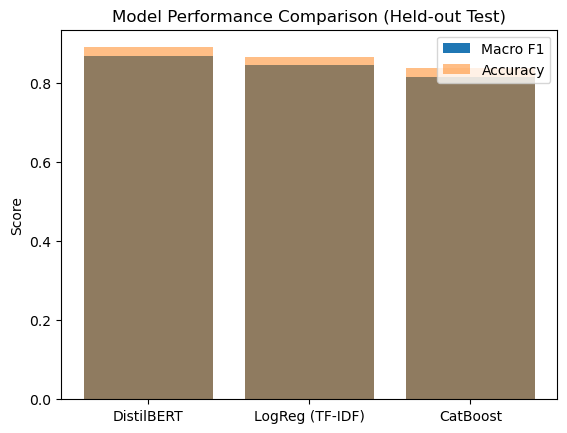

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(compare_df["model"], compare_df["macro_f1"], label="Macro F1")
plt.bar(compare_df["model"], compare_df["accuracy"], alpha=0.5, label="Accuracy")
plt.ylabel("Score")
plt.title("Model Performance Comparison (Held-out Test)")
plt.legend()
plt.show()

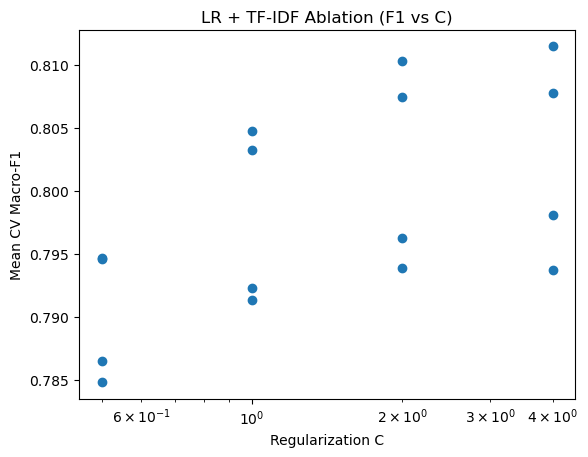

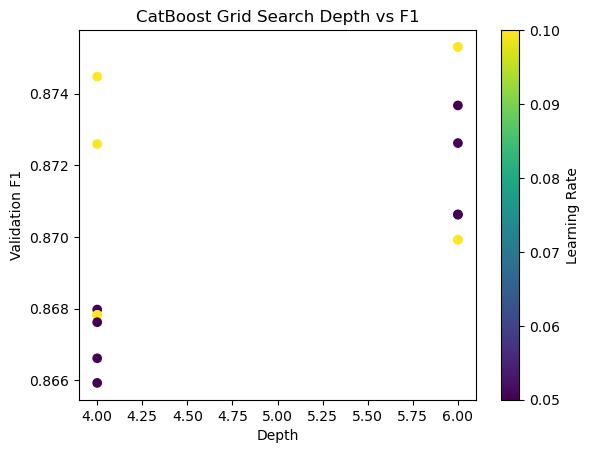

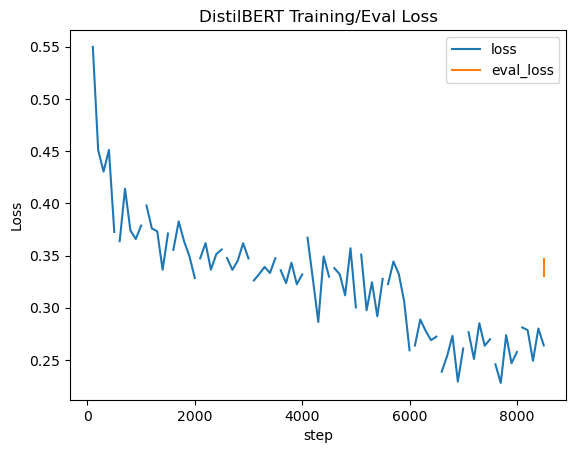

In [41]:
# Logistic Regression (ablation_df already built)
plt.figure()
plt.scatter(ablation_df["C"], ablation_df["cv_macro_f1_mean"], c="tab:blue")
plt.title("LR + TF-IDF Ablation (F1 vs C)")
plt.xlabel("Regularization C")
plt.ylabel("Mean CV Macro-F1")
plt.xscale("log")
plt.show()

# CatBoost grid search
plt.figure()
plt.scatter(sweep_df["depth"], sweep_df["val_F1"], c=sweep_df["learning_rate"], cmap="viridis")
plt.colorbar(label="Learning Rate")
plt.title("CatBoost Grid Search Depth vs F1")
plt.xlabel("Depth")
plt.ylabel("Validation F1")
plt.show()

# DistilBERT fine-tuning curve (use Trainer logs)
history = trainer.state.log_history
import pandas as pd
hist = pd.DataFrame([h for h in history if "loss" in h or "eval_loss" in h])
hist[["step","loss","eval_loss"]].plot(x="step", title="DistilBERT Training/Eval Loss")
plt.ylabel("Loss")
plt.show()


In [42]:
# Merge all model predictions if you like; here using DistilBERT for best semantic accuracy
df_insight = test_df_bert.copy()
df_insight["pred_label"] = np.where(df_insight["y_pred"] == 1, "pos", "neg")

aspect_summary = (
    df_insight.groupby("aspect")
    .agg(n=("pred_label","size"), pos=("pred_label", lambda s: (s=="pos").sum()), neg=("pred_label", lambda s: (s=="neg").sum())))
aspect_summary["pos_share"] = aspect_summary["pos"]/aspect_summary["n"]
aspect_summary["neg_share"] = aspect_summary["neg"]/aspect_summary["n"]
aspect_summary["sentiment_index"] = aspect_summary["pos_share"] - aspect_summary["neg_share"]
aspect_summary = aspect_summary.sort_values("sentiment_index", ascending=False)
display(aspect_summary)


,n,pos,neg,pos_share,neg_share,sentiment_index
aspect,,,,,,
ambience,4508,3709,799,0.822760,0.177240,0.645519
pricing,3271,2595,676,0.793335,0.206665,0.586671
service,8361,5845,2516,0.699079,0.300921,0.398158
food,9803,6026,3777,0.614710,0.385290,0.229420


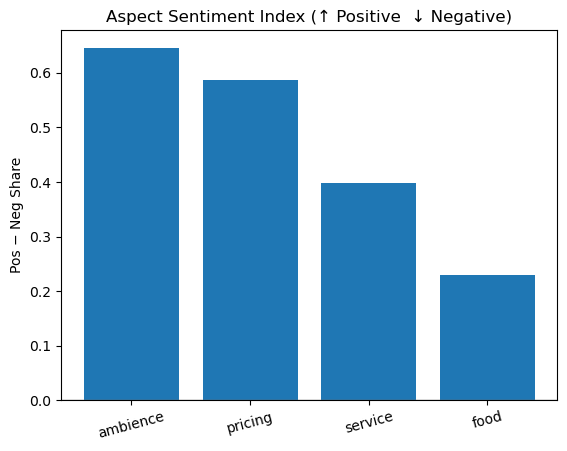

In [43]:
plt.figure()
plt.bar(aspect_summary.index, aspect_summary["sentiment_index"])
plt.axhline(0, color="gray", lw=1)
plt.title("Aspect Sentiment Index (↑ Positive  ↓ Negative)")
plt.ylabel("Pos − Neg Share")
plt.xticks(rotation=15)
plt.show()


In [44]:
top_neg = aspect_summary.head(3).index.tolist()
top_pos = aspect_summary.tail(3).index.tolist()
print(f"🔴 Main Pain Drivers (negative sentiment): {', '.join(top_neg)}")
print(f"🟢 Strength Areas (positive sentiment): {', '.join(top_pos)}")

🔴 Main Pain Drivers (negative sentiment): ambience, pricing, service
🟢 Strength Areas (positive sentiment): pricing, service, food


# Business-Specific Predictions

In [46]:
# Re-split with indices so we can map back to df_bal rows
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    df_bal["text_with_aspect"], df_bal["y"], df_bal.index,
    test_size=0.20, random_state=SEED, stratify=df_bal["strata"]
)

# Validation split (also keep indices, optional)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_full, y_train_full, idx_train_full,
    test_size=0.10, random_state=SEED, stratify=y_train_full
)



In [47]:
# test_df_bert already has: text_with_aspect, y_true, y_pred, aspect
# Attach original business_id (and stars) using idx_test order
test_df_bert["business_id"] = df_bal.loc[idx_test, "business_id"].values
if "stars" in df_bal.columns:
    test_df_bert["stars"] = df_bal.loc[idx_test, "stars"].values

# Label string for aggregation
test_df_bert["pred_label"] = np.where(test_df_bert["y_pred"] == 1, "pos", "neg")

# This is the df_insight you’ll aggregate from
df_insight = test_df_bert.copy()


In [49]:
df_biz = (df_insight.assign(pred_num=lambda d: np.where(d["pred_label"]=="pos", 1, -1)).groupby(["business_id","aspect"], as_index=False).agg(mean_sent=("pred_num","mean"), n=("pred_label","size")))

pivot = df_biz.pivot(index="business_id", columns="aspect", values="mean_sent").fillna(0)
pivot.head()


aspect,ambience,food,pricing,service
business_id,,,,
--ZVrH2X2QXBFdCilbirsw,0.000000,0.0,1.0,0.000000
-1MhPXk1FglglUAmuPLIGg,1.000000,0.0,0.0,1.000000
-3AooxIkg38UyUdlz5oXdw,0.666667,-0.2,-0.5,0.111111
-4dYswJy7SPcbcERvitmIg,0.000000,-1.0,-1.0,-1.000000
-6OjnX3ZdDOhHxWR60wysg,0.000000,-1.0,0.0,1.000000


In [50]:
missing_cols = {"business_id"} - set(df_insight.columns)
if missing_cols:
    raise ValueError(f"df_insight is missing columns: {missing_cols}. "f"Ensure you re-split with indices and attach from df_bal via idx_test.")


## Visualizations

In [51]:
# Build business × aspect aggregates (pos=+1, neg=−1) from your chosen model's df_insight
# df_insight must have: ['business_id','aspect','pred_label'] and optionally 'text_with_aspect'
df_biz = (
    df_insight
      .assign(pred_num=lambda d: np.where(d["pred_label"]=="pos", 1, -1))
      .groupby(["business_id","aspect"], as_index=False)
      .agg(mean_sent=("pred_num","mean"),  # −1..+1
           n=("pred_label","size"),
           pos=("pred_label", lambda s: (s=="pos").sum()),
           neg=("pred_label", lambda s: (s=="neg").sum()))
)
df_biz["pos_share"] = df_biz["pos"] / df_biz["n"].clip(lower=1)
df_biz["neg_share"] = df_biz["neg"] / df_biz["n"].clip(lower=1)

# (Optional) keep a sentence-level table for examples (pull from df_insight)
# df_insight needs 'text_with_aspect' and 'proba' only if you want examples
if "text_with_aspect" in df_insight.columns:
    ex_cols = ["business_id","aspect","pred_label","text_with_aspect"]
    df_ex = df_insight.loc[:, [c for c in ex_cols if c in df_insight.columns]].copy()
else:
    df_ex = None


/var/folders/5q/xn4tw5ss2x7bd35dvqlb9xgc0000gn/T/ipykernel_59412/592348157.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


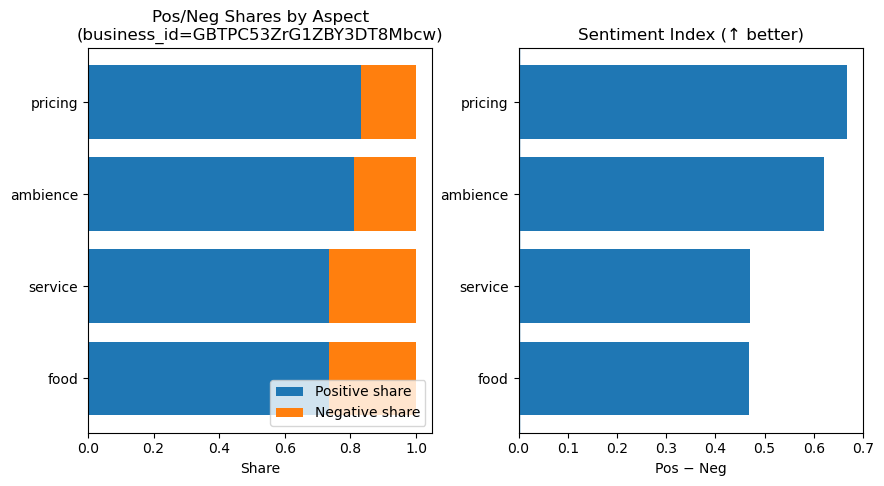

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_business_scorecard(business_id, min_n=10):
    sub = df_biz[df_biz["business_id"] == business_id].copy()
    if sub.empty:
        print("No rows for business:", business_id); return

    # Filter very tiny aspect coverage if desired
    sub = sub[sub["n"] >= min_n].copy()
    if sub.empty:
        print("No aspects with n >=", min_n, "for business:", business_id); return

    sub = sub.sort_values("pos_share", ascending=True)
    aspects = sub["aspect"].tolist()

    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1,1], wspace=0.25)

    # Panel A: stacked shares
    ax1 = fig.add_subplot(gs[0,0])
    ax1.barh(aspects, sub["pos_share"], label="Positive share")
    ax1.barh(aspects, sub["neg_share"], left=sub["pos_share"], label="Negative share")
    ax1.set_xlabel("Share")
    ax1.set_title(f"Pos/Neg Shares by Aspect\n(business_id={business_id})")
    ax1.legend(loc="lower right")

    # Panel B: sentiment index
    ax2 = fig.add_subplot(gs[0,1])
    sent_index = sub["pos_share"] - sub["neg_share"]
    ax2.barh(aspects, sent_index)
    ax2.axvline(0, linewidth=1)
    ax2.set_xlabel("Pos − Neg")
    ax2.set_title("Sentiment Index (↑ better)")

    plt.tight_layout()
    plt.show()

# example
plot_business_scorecard(business_id="GBTPC53ZrG1ZBY3DT8Mbcw")


🔴 Pains


,aspect,n,sent_index
0,food,94,0.468085
1,service,121,0.471074
2,ambience,58,0.620690


🟢 Strengths


,aspect,n,sent_index
0,pricing,30,0.666667
1,ambience,58,0.620690
2,service,121,0.471074


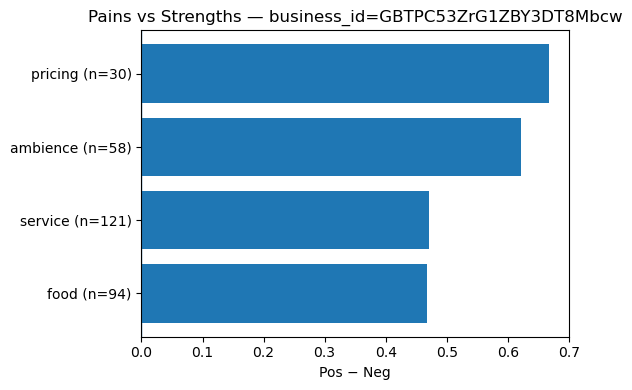

In [62]:
def business_pains_strengths(business_id, top_k=3, min_n=10):
    sub = df_biz.query("business_id == @business_id and n >= @min_n").copy()
    if sub.empty:
        print("No data for business:", business_id); return
    sub["sent_index"] = sub["pos_share"] - sub["neg_share"]
    pains = sub.sort_values("sent_index").head(top_k)[["aspect","n","sent_index"]]
    strengths = sub.sort_values("sent_index", ascending=False).head(top_k)[["aspect","n","sent_index"]]

    print("🔴 Pains")
    display(pains.reset_index(drop=True))
    print("🟢 Strengths")
    display(strengths.reset_index(drop=True))

    # quick bar
    plt.figure(figsize=(6,4))
    show = pd.concat([strengths.assign(kind="Strength"), pains.assign(kind="Pain")], axis=0)
    show = show.sort_values("sent_index")
    y = [f"{a} (n={int(n)})" for a,n in zip(show["aspect"], show["n"])]
    plt.barh(y, show["sent_index"])
    plt.axvline(0, linewidth=1)
    plt.title(f"Pains vs Strengths — business_id={business_id}")
    plt.xlabel("Pos − Neg")
    plt.tight_layout()
    plt.show()

# Example:
business_pains_strengths("GBTPC53ZrG1ZBY3DT8Mbcw", top_k=3)


In [63]:
import re

_aspect_pat = re.compile(r"\[ASPECT=([^\]]+)\]\s*")

def _strip_prefix(s):
    m = _aspect_pat.search(s) if isinstance(s, str) else None
    if not m: return s
    return s[m.end():].strip()

def show_example_sentences(business_id, aspect=None, k_pos=3, k_neg=3):
    if df_ex is None:
        print("df_ex not available — ensure df_insight had text_with_aspect.")
        return
    sub = df_ex[df_ex["business_id"] == business_id].copy()
    if aspect:
        sub = sub[sub["aspect"] == aspect]
    if sub.empty:
        print("No examples for that selection.")
        return
    pos_examples = sub[sub["pred_label"]=="pos"].head(k_pos)["text_with_aspect"].map(_strip_prefix).tolist()
    neg_examples = sub[sub["pred_label"]=="neg"].head(k_neg)["text_with_aspect"].map(_strip_prefix).tolist()

    print(f"Business: {business_id}  Aspect: {aspect or 'ALL'}")
    print("\n🟢 Positive examples")
    for i, t in enumerate(pos_examples, 1):
        print(f"{i}. {t}")
    print("\n🔴 Negative examples")
    for i, t in enumerate(neg_examples, 1):
        print(f"{i}. {t}")

# Example:
show_example_sentences("GBTPC53ZrG1ZBY3DT8Mbcw", aspect="service")


Business: GBTPC53ZrG1ZBY3DT8Mbcw  Aspect: service

🟢 Positive examples
1. Late night arrival in NOLA so got amazing service from Gary!
2. Service was great and we had a pretty neat seat next to the kitchen which is surrounded with glass.
3. Seems like a good staff to go with it.

🔴 Negative examples
1. Very disappointed with the food and service.
2. I don't know if the food quality is worth the rude behavior by the staff.
3. Basically if you want a good meal at a good price with good service this is NOT the place to go.


/var/folders/5q/xn4tw5ss2x7bd35dvqlb9xgc0000gn/T/ipykernel_59412/592348157.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


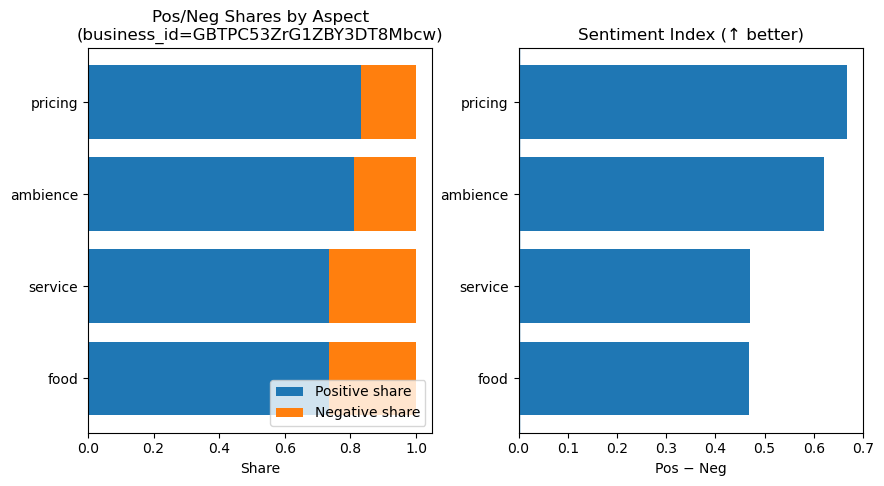

🔴 Pains


,aspect,n,sent_index
0,food,94,0.468085
1,service,121,0.471074
2,ambience,58,0.620690


🟢 Strengths


,aspect,n,sent_index
0,pricing,30,0.666667
1,ambience,58,0.620690
2,service,121,0.471074


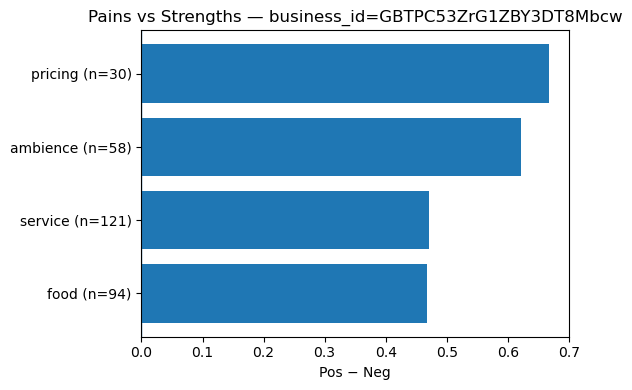


=== Examples for WORST aspect: food ===
Business: GBTPC53ZrG1ZBY3DT8Mbcw  Aspect: food

🟢 Positive examples
1. I repeat, stay out of the quarter for food!!!
2. My meal started with the crispy Brussel Sprouts.

🔴 Negative examples
1. I did my typical thing by ordering an entrée, a cocktail, and a dessert.
2. So, I usually share or offer friends to try my dish, but in a flurry of utensils flying from my plate to my mouth, by the time I looked up and took a breath, I was already done...
3. Our waiter was not very talkative, he just took the order and brought the food.
4. We dragged our hungover asses out of bed and walked in here with hopes of eating some delicious food and a well needed dose of caffeine.

=== Examples for BEST aspect: pricing ===
Business: GBTPC53ZrG1ZBY3DT8Mbcw  Aspect: pricing

🟢 Positive examples
1. Eggs in a jar crowned with big beautiful fried shrimp was worth the the hype.
2. It is a great deal and there are drink specials as well.
3. That said, it was great place

In [64]:
def business_dashboard(business_id, min_n=10, top_k=3):
    plot_business_scorecard(business_id, min_n=min_n)
    business_pains_strengths(business_id, top_k=top_k, min_n=min_n)
    if df_ex is not None:
        # Show examples for the single worst and best aspect
        sub = df_biz[df_biz["business_id"] == business_id].copy()
        sub["sent_index"] = sub["pos_share"] - sub["neg_share"]
        sub = sub[sub["n"] >= min_n]
        if not sub.empty:
            worst = sub.sort_values("sent_index").iloc[0]["aspect"]
            best  = sub.sort_values("sent_index", ascending=False).iloc[0]["aspect"]
            print("\n=== Examples for WORST aspect:", worst, "===")
            show_example_sentences(business_id, aspect=worst, k_pos=2, k_neg=4)
            print("\n=== Examples for BEST aspect:", best, "===")
            show_example_sentences(business_id, aspect=best, k_pos=4, k_neg=2)

# Example:
business_dashboard("GBTPC53ZrG1ZBY3DT8Mbcw", min_n=10, top_k=3)


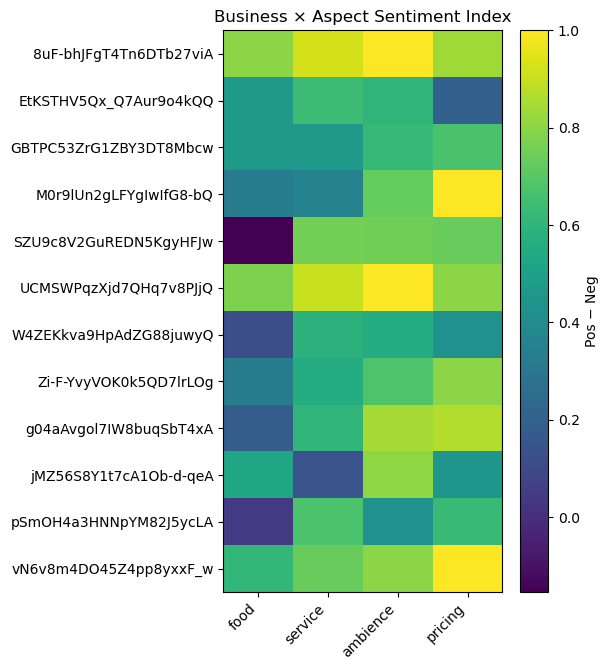

aspect,food,service,ambience,pricing
business_id,,,,
8uF-bhJFgT4Tn6DTb27viA,0.800000,0.925926,1.000000,0.833333
EtKSTHV5Qx_Q7Aur9o4kQQ,0.464789,0.636364,0.600000,0.200000
GBTPC53ZrG1ZBY3DT8Mbcw,0.468085,0.471074,0.620690,0.666667
M0r9lUn2gLFYgIwIfG8-bQ,0.333333,0.360000,0.727273,1.000000
SZU9c8V2GuREDN5KgyHFJw,-0.153846,0.757576,0.750000,0.733333
UCMSWPqzXjd7QHq7v8PJjQ,0.771429,0.902439,1.000000,0.800000
W4ZEKkva9HpAdZG88juwyQ,0.125000,0.586207,0.562500,0.428571
Zi-F-YvyVOK0k5QD7lrLOg,0.333333,0.562500,0.684211,0.800000
g04aAvgol7IW8buqSbT4xA,0.185185,0.600000,0.846154,0.866667


In [65]:
def multi_business_matrix(business_ids=None, top_n_businesses=15, aspects_order=None):
    mat = df_biz.copy()
    mat["sent_index"] = mat["pos_share"] - mat["neg_share"]

    if business_ids is None:
        top_biz = (mat.groupby("business_id")["n"].sum()
                      .sort_values(ascending=False)
                      .head(top_n_businesses).index)
        mat = mat[mat["business_id"].isin(top_biz)]
    else:
        mat = mat[mat["business_id"].isin(business_ids)]

    if aspects_order is None:
        aspects_order = list(mat.groupby("aspect")["n"].sum().sort_values(ascending=False).index)

    pivot = mat.pivot(index="business_id", columns="aspect", values="sent_index").reindex(columns=aspects_order)
    pivot = pivot.fillna(0.0)

    plt.figure(figsize=(max(6, 0.6*len(aspects_order)), 0.4*len(pivot) + 2))
    plt.imshow(pivot.values, aspect="auto")
    plt.xticks(range(len(aspects_order)), aspects_order, rotation=45, ha="right")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.colorbar(label="Pos − Neg")
    plt.title("Business × Aspect Sentiment Index")
    plt.tight_layout()
    plt.show()

    return pivot

# Example:
multi_business_matrix(top_n_businesses=12)


In [66]:
def business_card_table(business_id, min_n=10):
    sub = df_biz.query("business_id == @business_id and n >= @min_n").copy()
    if sub.empty:
        print("No data"); return
    sub["sent_index"] = sub["pos_share"] - sub["neg_share"]
    card = sub.loc[:, ["aspect","n","pos_share","neg_share","sent_index"]].sort_values("sent_index", ascending=False)
    display(card.reset_index(drop=True).head(8))

# Example:
business_card_table("GBTPC53ZrG1ZBY3DT8Mbcw")


,aspect,n,pos_share,neg_share,sent_index
0,pricing,30,0.833333,0.166667,0.666667
1,ambience,58,0.810345,0.189655,0.620690
2,service,121,0.735537,0.264463,0.471074
3,food,94,0.734043,0.265957,0.468085


/var/folders/5q/xn4tw5ss2x7bd35dvqlb9xgc0000gn/T/ipykernel_59412/2023397478.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


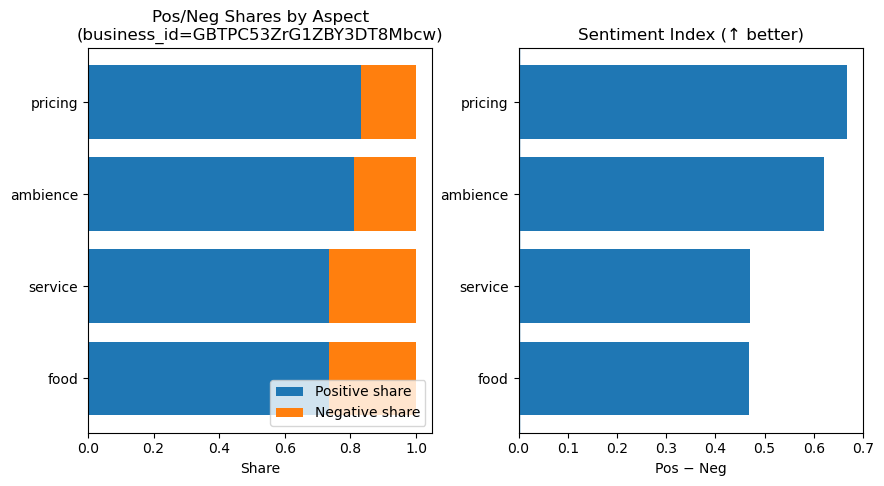

🔴 Pains


,aspect,n,sent_index
0,food,94,0.468085
1,service,121,0.471074
2,ambience,58,0.620690


🟢 Strengths


,aspect,n,sent_index
0,pricing,30,0.666667
1,ambience,58,0.620690
2,service,121,0.471074


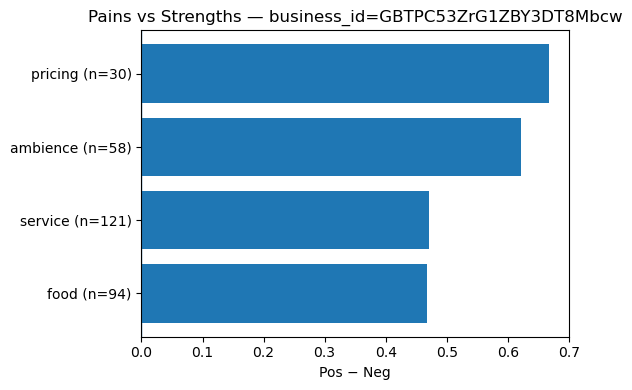

Business: GBTPC53ZrG1ZBY3DT8Mbcw  Aspect: ALL

🟢 Positive examples
1. My friend thought I was brilliant for reserving a table at Luke during happy hour (who knew you could do that?!).
2. Late night arrival in NOLA so got amazing service from Gary!
3. I repeat, stay out of the quarter for food!!!

🔴 Negative examples
1. Very disappointed with the food and service.
2. I don't know if the food quality is worth the rude behavior by the staff.
3. Basically if you want a good meal at a good price with good service this is NOT the place to go.


/var/folders/5q/xn4tw5ss2x7bd35dvqlb9xgc0000gn/T/ipykernel_59412/2023397478.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


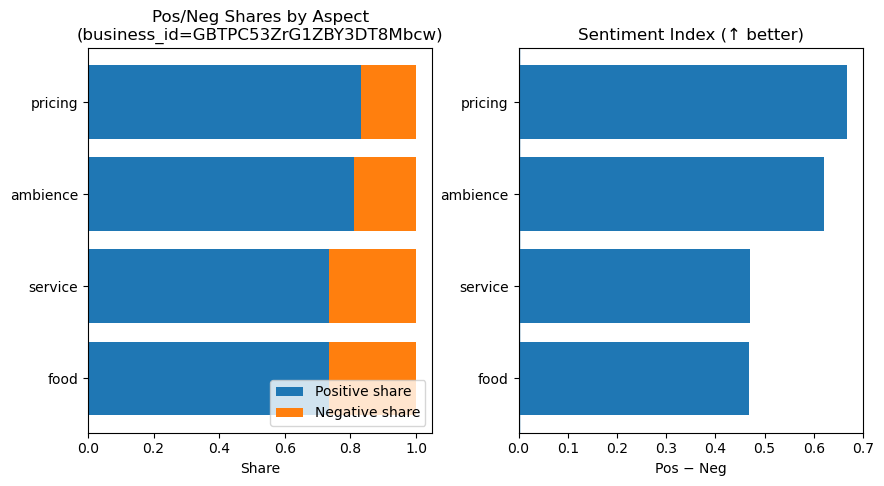

🔴 Pains


,aspect,n,sent_index
0,food,94,0.468085
1,service,121,0.471074
2,ambience,58,0.620690


🟢 Strengths


,aspect,n,sent_index
0,pricing,30,0.666667
1,ambience,58,0.620690
2,service,121,0.471074


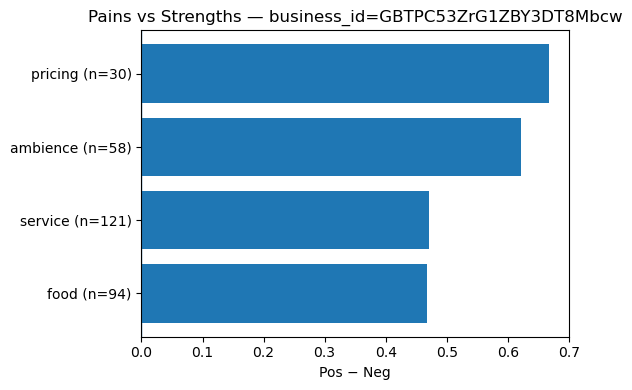


=== Examples for WORST aspect: food ===
Business: GBTPC53ZrG1ZBY3DT8Mbcw  Aspect: food

🟢 Positive examples
1. I repeat, stay out of the quarter for food!!!
2. My meal started with the crispy Brussel Sprouts.

🔴 Negative examples
1. I did my typical thing by ordering an entrée, a cocktail, and a dessert.
2. So, I usually share or offer friends to try my dish, but in a flurry of utensils flying from my plate to my mouth, by the time I looked up and took a breath, I was already done...
3. Our waiter was not very talkative, he just took the order and brought the food.
4. We dragged our hungover asses out of bed and walked in here with hopes of eating some delicious food and a well needed dose of caffeine.

=== Examples for BEST aspect: pricing ===
Business: GBTPC53ZrG1ZBY3DT8Mbcw  Aspect: pricing

🟢 Positive examples
1. Eggs in a jar crowned with big beautiful fried shrimp was worth the the hype.
2. It is a great deal and there are drink specials as well.
3. That said, it was great place

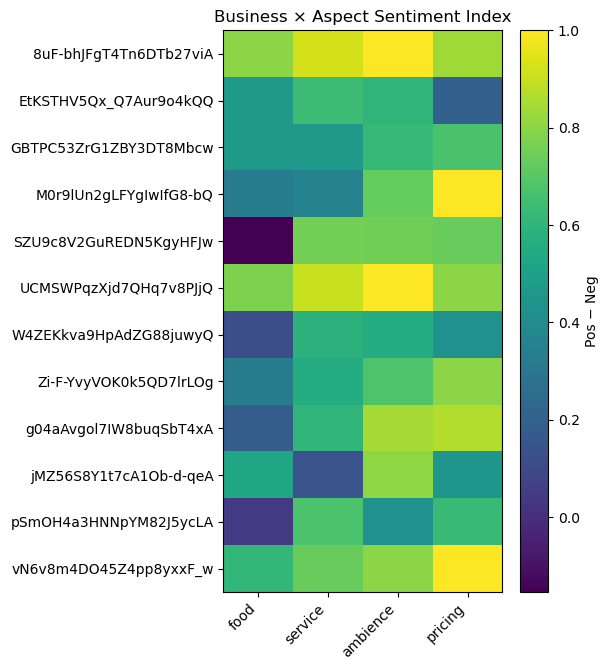

,aspect,n,pos_share,neg_share,sent_index
0,pricing,30,0.833333,0.166667,0.666667
1,ambience,58,0.810345,0.189655,0.620690
2,service,121,0.735537,0.264463,0.471074
3,food,94,0.734043,0.265957,0.468085


In [59]:
# Pick a real business_id from your aggregates
example_biz = df_biz.groupby("business_id")["n"].sum().sort_values(ascending=False).index[0]

plot_business_scorecard(example_biz, min_n=10)
business_pains_strengths(example_biz, top_k=3, min_n=10)
show_example_sentences(example_biz, aspect=None, k_pos=3, k_neg=3)  # needs df_ex
business_dashboard(example_biz, min_n=10, top_k=3)

# Compare multiple businesses (returns the matrix DataFrame too)
_ = multi_business_matrix(top_n_businesses=12)

# Small tabular “card” for slides
business_card_table(example_biz, min_n=10)


## Star Rating Correlation

In [67]:
import pandas as pd
import numpy as np

# Step 1: numeric sentiment encoding
df_insight["sent_num"] = np.where(df_insight["pred_label"] == "pos", 1, -1)

# Step 2: business-aspect sentiment aggregation
df_biz_aspect = (
    df_insight
    .groupby(["business_id", "aspect"])
    .agg(sentiment_mean=("sent_num", "mean"))
    .reset_index()
)

# Step 3: pivot so each business = one row, each aspect = one column
df_pivot = df_biz_aspect.pivot(index="business_id", columns="aspect", values="sentiment_mean").fillna(0)

# Step 4: merge with average star rating per business
biz_stars = df_insight.groupby("business_id")["stars"].mean().reset_index()
df_merge = pd.merge(df_pivot, biz_stars, on="business_id")
df_merge.head()


,business_id,ambience,food,pricing,service,stars
0,--ZVrH2X2QXBFdCilbirsw,0.000000,0.0,1.0,0.000000,5.000000
1,-1MhPXk1FglglUAmuPLIGg,1.000000,0.0,0.0,1.000000,2.800000
2,-3AooxIkg38UyUdlz5oXdw,0.666667,-0.2,-0.5,0.111111,3.103448
3,-4dYswJy7SPcbcERvitmIg,0.000000,-1.0,-1.0,-1.000000,1.666667
4,-6OjnX3ZdDOhHxWR60wysg,0.000000,-1.0,0.0,1.000000,2.666667


In [68]:
corrs = df_merge.corr(numeric_only=True)["stars"].drop("stars").sort_values(ascending=False)
corrs


service     0.528178
food        0.492337
pricing     0.294118
ambience    0.290336
Name: stars, dtype: float64

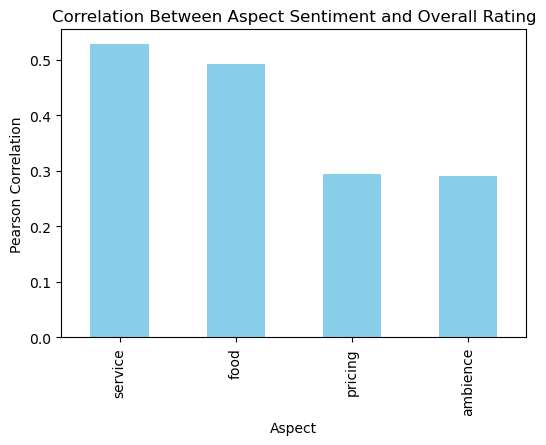

In [69]:
import matplotlib.pyplot as plt

corrs.plot(kind="bar", color="skyblue", figsize=(6,4))
plt.title("Correlation Between Aspect Sentiment and Overall Rating")
plt.ylabel("Pearson Correlation")
plt.xlabel("Aspect")
plt.show()


In [72]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "statsmodels"])

import statsmodels.api as sm

X = df_merge[["ambience", "pricing", "service", "food"]]
y = df_merge["stars"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     818.9
Date:                Tue, 14 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:07:09   Log-Likelihood:                -4546.8
No. Observations:                3488   AIC:                             9104.
Df Residuals:                    3483   BIC:                             9134.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0413      0.018    166.111      0.0